In [19]:
import numpy as np 
import pandas as pd 
import pickle    
import matplotlib
import matplotlib.pyplot as plt
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image

# Needed for custom colour mapping!
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors

In [20]:
#Make two colour maps to differentiate the positive values from the negative values 
#Method ListedColormap used for custom colour map 
c = mcolors.ColorConverter()
positive_cm = ListedColormap([c.to_rgb('#d63b36')])
negative_cm = ListedColormap([c.to_rgb('#28aee4')]) 

In [21]:
#Load pickle file we generated previously
year = str(2019)
with open('./'+year+'FullDataset.pkl','rb') as f:
    game_data = pickle.load(f)

In [22]:
#Dictionary Initialization for our cleaned and condensed league data
league_data = {}

league_data['Shot'] = {}
league_data['Shot']['x'] = []
league_data['Shot']['y'] = []

league_data['Goal'] = {}
league_data['Goal']['x'] = []
league_data['Goal']['y'] = []

In [23]:
event_types = ['Shot', 'Goal']

#Loop over every game played in the 2019 season and extract the info into our dict

#Loop over each game 
for data in game_data:
    #Check to see if this game has live data
    if 'liveData' not in data:
        continue
    
    #Drilling down into the dataset to extract play by play info on the game
    plays = data['liveData']['plays']['allPlays']
    
    for play in plays: #For each play
        for event in event_types: #For each event (Shot,Goal)
            if play['result']['event'] in [event]:
                if 'x' in play['coordinates']: #if the event contains coordinates
                    #Save coordinates to the growing list
                    league_data[event]['x'].append(play['coordinates']['x'])
                    league_data[event]['y'].append(play['coordinates']['y'])

In [24]:
#Initialize the player dictionary
full_name = 'Cam Atkinson'
player_data = {}

player_data['Shot'] = {}
player_data['Shot']['x'] = []
player_data['Shot']['y'] = []

player_data['Goal'] = {}
player_data['Goal']['x'] = []
player_data['Goal']['y'] = []

In [25]:
event_types = ['Shot', 'Goal']

#Loop over every game played in the 2019 season and extract the info into our dict

#Loop over each game 
for data in game_data:
    #Check to see if this game has live data
    if 'liveData' not in data:
        continue
    
    #Drilling down into the dataset to extract play by play info on the game
    plays = data['liveData']['plays']['allPlays']
    
    for play in plays: #For each play
        if 'players' in play:
            for player in play['players']:
                if player['player']['fullName'] in [full_name] and player['playerType'] in ['Shooter', 'Scorer']:    
                    for event in event_types: #For each event (Shot,Goal)
                        if play['result']['event'] in [event]:
                            if 'x' in play['coordinates']: #if the event contains coordinates
                                #Save coordinates to the growing list
                                player_data[event]['x'].append(play['coordinates']['x'])
                                player_data[event]['y'].append(play['coordinates']['y'])

In [26]:
#Calculating Basic Statistics

#Get total number of shots made by the player
player_total_shots = len(player_data['Shot']['x']) + len(player_data['Goal']['x'])

#Get players goal score percentage
player_goal_pct = len(player_data['Goal']['x']) / player_total_shots

#Get the total number of shots taken in the league
league_total_shots = len(league_data['Shot']['x']) + len(league_data['Goal']['x'])

#Get league percentage
league_goal_pct = len(league_data['Goal']['x']) / league_total_shots

#Get spread of SOG (Shots on Goal)
PL_e_spread = player_goal_pct - league_goal_pct

print("Player Total Shots: " + str(player_total_shots))
print("Player SOG %: " + str(player_goal_pct))
print("League Total Shots: " + str(league_total_shots))
print("League SOG %: " + str(league_goal_pct))
print("Player vs League SOG% Spread: " + str(PL_e_spread))

Player Total Shots: 148
Player SOG %: 0.08108108108108109
League Total Shots: 68499
League SOG %: 0.0970525117154995
Player vs League SOG% Spread: -0.015971430634418415


In [27]:
#Define dimensions and grid size

# To keep the aspect ration correct we use a square figure size
xbnds = np.array([-100.,100.0])
ybnds = np.array([-100,100])
extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]

#Bin in 30 unit increments
gridsize = 30; mincnt = 0

In [28]:
# First concatenate the arrays for x and y league data
league_x_all_shots = league_data['Shot']['x'] + league_data['Goal']['x'];
league_y_all_shots = league_data['Shot']['y'] + league_data['Goal']['y']
    
# Perform the coordinate flipping!
league_x_all_shots_normalized = [];
league_y_all_shots_normalized = []

# Enumerate the list so we can use the index for y also
for i,s in enumerate(league_x_all_shots):
    if league_x_all_shots[i] < 0:
        league_x_all_shots_normalized.append(-league_x_all_shots[i])
        league_y_all_shots_normalized.append(-league_y_all_shots[i])
    else:
        league_x_all_shots_normalized.append(league_x_all_shots[i])
        league_y_all_shots_normalized.append(league_y_all_shots[i])
        
# Do the same treatment for the goals
league_x_goal_normalized = [];
league_y_goal_normalized=[]

for i,s in enumerate(league_data['Goal']['x']):
    if league_data['Goal']['x'][i] <0:
       league_x_goal_normalized.append(-league_data['Goal']['x'][i])
       league_y_goal_normalized.append(-league_data['Goal']['y'][i])
    else:
       league_x_goal_normalized.append(league_data['Goal']['x'][i])
       league_y_goal_normalized.append(league_data['Goal']['y'][i])

In [29]:
# First we will used the hexbin function to simply bucket our shot data into basically a 2D histogram
league_hex_data = plt.hexbin(league_x_all_shots_normalized,
   league_y_all_shots_normalized,gridsize=gridsize,
   extent=extent,mincnt=mincnt,alpha=0.0) 

# Now we extract the bin coordinates and counts
league_verts = league_hex_data.get_offsets();
league_shot_frequency = league_hex_data.get_array();

# Do the same thing for the goal data
league_goal_hex_data =  plt.hexbin(league_x_goal_normalized,
   league_y_goal_normalized,gridsize=gridsize,
   extent=extent,mincnt=mincnt,alpha=0.0)

# Since the grid is the same we can use a shared bin coordinate set from the above. So here we just get the counts
league_goal_frequency = league_goal_hex_data.get_array();

In [30]:
# First concatenate the arrays for x and y player data
player_x_all_shots = player_data['Shot']['x'] + player_data['Goal']['x'];
player_y_all_shots = player_data['Shot']['y'] + player_data['Goal']['y']
    
# Perform the coordinate flipping!
player_x_all_shots_normalized = [];
player_y_all_shots_normalized = []

# Enumerate the list so we can use the index for y also
for i,s in enumerate(player_x_all_shots):
    if player_x_all_shots[i] < 0:
        player_x_all_shots_normalized.append(-player_x_all_shots[i])
        player_y_all_shots_normalized.append(-player_y_all_shots[i])
    else:
        player_x_all_shots_normalized.append(player_x_all_shots[i])
        player_y_all_shots_normalized.append(player_y_all_shots[i])
        
# Do the same treatment for the goals
player_x_goal_normalized = [];
player_y_goal_normalized=[]

for i,s in enumerate(player_data['Goal']['x']):
    if player_data['Goal']['x'][i] <0:
       player_x_goal_normalized.append(-player_data['Goal']['x'][i])
       player_y_goal_normalized.append(-player_data['Goal']['y'][i])
    else:
       player_x_goal_normalized.append(player_data['Goal']['x'][i])
       player_y_goal_normalized.append(player_data['Goal']['y'][i])

In [31]:
# First we will used the hexbin function to simply bucket our shot data into basically a 2D histogram
player_hex_data = plt.hexbin(player_x_all_shots_normalized,
   player_y_all_shots_normalized,gridsize=gridsize,
   extent=extent,mincnt=mincnt,alpha=0.0) 

# Now we extract the bin coordinates and counts
player_verts = player_hex_data.get_offsets();
player_shot_frequency = player_hex_data.get_array();

# Do the same thing for the goal data
player_goal_hex_data =  plt.hexbin(player_x_goal_normalized,
   player_y_goal_normalized,gridsize=gridsize,
   extent=extent,mincnt=mincnt,alpha=0.0)

# Since the grid is the same we can use a shared bin coordinate set from the above. So here we just get the counts
player_goal_frequency = player_goal_hex_data.get_array();
player_goal_verts = player_goal_hex_data.get_offsets();

In [32]:
# Using matplotlib we create a new figure for plotting
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# Clean up the figure to be completely blank
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
fig.patch.set_alpha(0.0)

# Remove the labelling of axes
ax.set_xticklabels(labels = [''], fontsize = 18,
   alpha = .7,minor=False)
ax.set_yticklabels(labels = [''], fontsize = 18,
   alpha = .7,minor=False)

# Using pillow to get the rink image and extract the image size
I = Image.open('/Users/johnkriston/Downloads/half.png')
ax.imshow(I); width, height = I.size

<ipython-input-32-99822c582b98>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = [''], fontsize = 18,
<ipython-input-32-99822c582b98>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels = [''], fontsize = 18,


In [33]:
# Calculate the scaling factor and offset (trial and error)
scalingx=width/100-0.6;
scalingy=height/100+0.5;
x_trans=33;
y_trans=height/2

# We will want to scale the size of our hex bins with the image so we calculate a "radius" scaling factor here
S = 3.8*scalingx;

In [34]:
#hex size is the shooting frequency
#color represents his efficiency

# Get some lists initialised 
league_efficiency = []
player_efficiency = []
relative_efficiency = []

# Looping over the league shots (which are the same in length as player)
for i in range(0,len(league_shot_frequency)):
    
    # We will only look at positions on the ice where the player or
    #league had more than two shots during the season
    if league_shot_frequency[i]<2 or player_shot_frequency[i]<2:
        continue
    
    # Calculate the efficiencies 
    league_efficiency.append(league_goal_frequency[i]/league_shot_frequency[i])
    
    player_efficiency.append(player_goal_frequency[i]/player_shot_frequency[i])
    
    # And the relative efficiency
    relative_efficiency.append((player_goal_frequency[i]/player_shot_frequency[i]-(league_goal_frequency[i]/league_shot_frequency[i])))
    
    # Keep track of the max so we can scale the colour and radius of the hex plot after
    max_league_efficiency = max(league_efficiency)
    max_player_efficiency = max(player_efficiency)
    max_relative_efficiency = max(relative_efficiency)
    min_relative_efficiency = min(relative_efficiency)

In [35]:
# Loop over the locations and draw the hex
for i,v in enumerate(player_verts):
    # Here we will only include locations where the player made at
    #least on shot.  We will adjust this later for plotting.
    if player_shot_frequency[i] < 1:continue
    
    # Scaling the frequencies
    scaled_player_shot_frequency = player_shot_frequency[i]/max(player_shot_frequency)
    
    # Calculate a radius of the hex
    radius = S*math.sqrt(scaled_player_shot_frequency)
   
    # Find the player efficiency and relative at this point on the ice.  
    player_efficiency = player_goal_frequency[i]/player_shot_frequency[i]
    league_efficiency = league_goal_frequency[i]/league_shot_frequency[i]
     
    relative_efficiency = player_efficiency - league_efficiency
  
    # Since there can be positive and negative efficiencies(relative) we colour the more efficient locations red and the less blue.
    if relative_efficiency>0:
        colour = positive_cm(math.pow(relative_efficiency,0.1))
    else:
        colour = negative_cm(math.pow(-relative_efficiency,0.1))
   
    # And finally we plot   
    hex_three = RegularPolygon((x_trans+v[0]*scalingx,
       y_trans-v[1]*scalingy),numVertices=6, radius=radius,
       orientation=np.radians(0),facecolor=colour,alpha=1,
       edgecolor=None)
    ax.add_patch(hex_three)

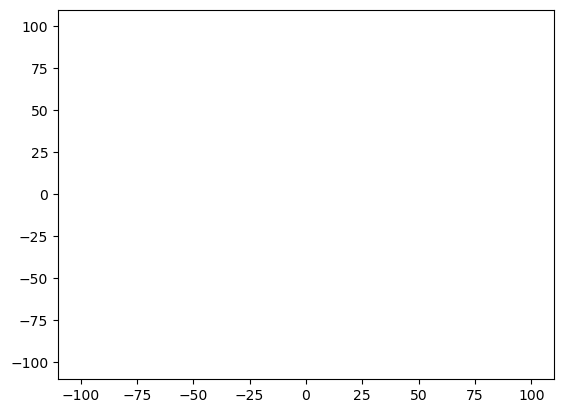

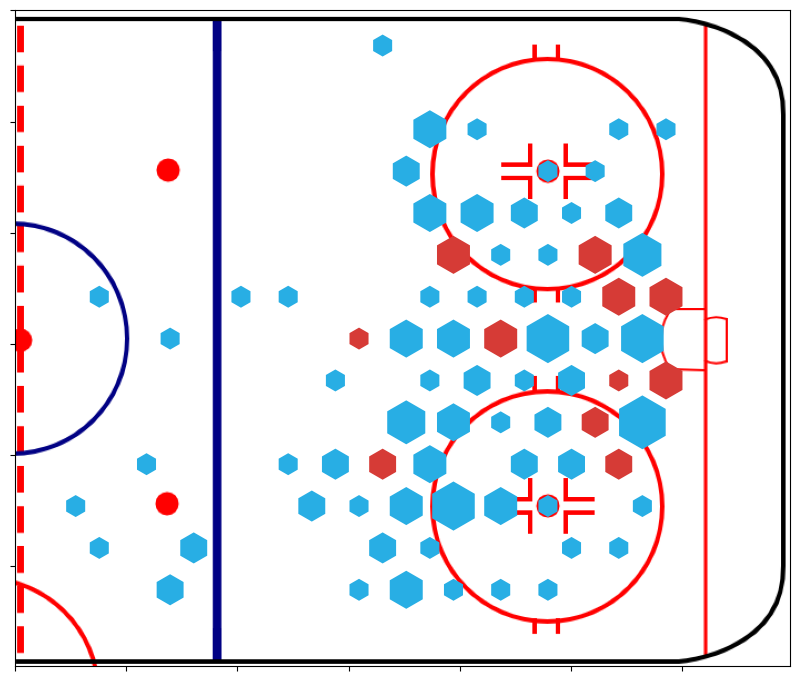

In [36]:
plt.show()